<a href="https://colab.research.google.com/github/Nobel712/Transformer/blob/main/VIT%2BGradCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [10]:
!kaggle datasets download -d tongpython/cat-and-dog

 97% 212M/218M [00:01<00:00, 111MB/s]
100% 218M/218M [00:01<00:00, 119MB/s]


In [11]:
!pip install tensorflow_addons

In [12]:
!pip install patchify

In [13]:

import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import*
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from patchify import patchify
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,ReduceLROnPlateau,EarlyStopping,TensorBoard
from tensorflow.keras.layers import*
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import os
import gc
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm


AUTOTUNE = tf.data.experimental.AUTOTUNE

In [14]:
from zipfile import ZipFile
with ZipFile('/content/cat-and-dog.zip','r') as zp:
  zp.extractall('/content')

In [15]:
num_classes = 2
input_shape = (224, 224, 3)
learning_rate = 1e-4 #0.001
weight_decay = 0.0001
batch_size = 16 #256
num_epochs = 100
# We'll resize input images to this size
image_size =  224
# Size of the patches to be extract from the input images
patch_size = 7
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 8
# Size of the dense layers of the final classifier
mlp_head_units = [56, 28] #[1024, 512]
num_patches=1024

In [16]:
train_dir = "/content/training_set/training_set"
test_dir = "/content/test_set/test_set"

In [17]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 16

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)



test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    image_size=IMG_SIZE,
    label_mode='categorical',
    batch_size=BATCH_SIZE
)

# Split the test_data into validation and test subsets
num_samples = test_data.cardinality().numpy()
validation_samples = int(0.2 * num_samples)  # 80% for validation
test_samples = num_samples - validation_samples

validation_data = test_data.take(validation_samples)
test_data = test_data.skip(validation_samples)



# Cache and prefetch the validation and test data
validation_data = validation_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 8005 files belonging to 2 classes.
Found 2023 files belonging to 2 classes.


In [18]:
print(len(validation_data))

25


In [19]:
print(len(train_data))

501


In [20]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor = 0.2, width_factor = 0.2
        ),
    ],
     name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.


In [21]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation = tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [22]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        #print(patches.shape)
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

(1, 224, 224, 3)
Image size: 224 X 224
Patch size: 7 X 7
Patches per image: 1024
Elements per patch: 147


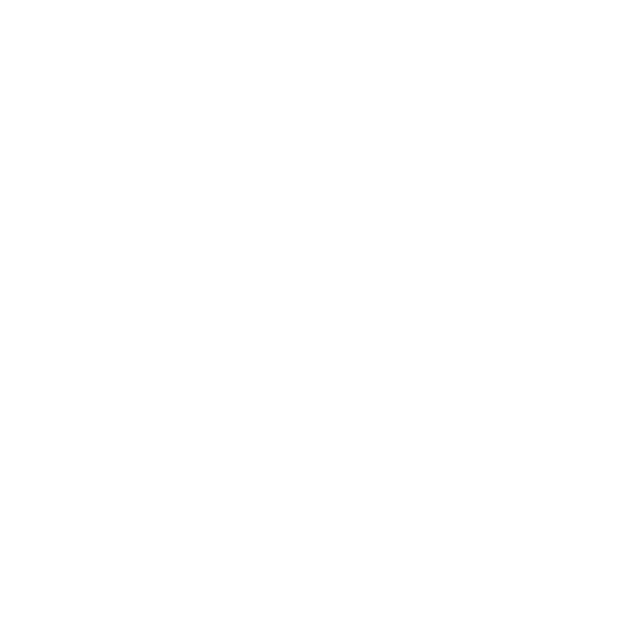

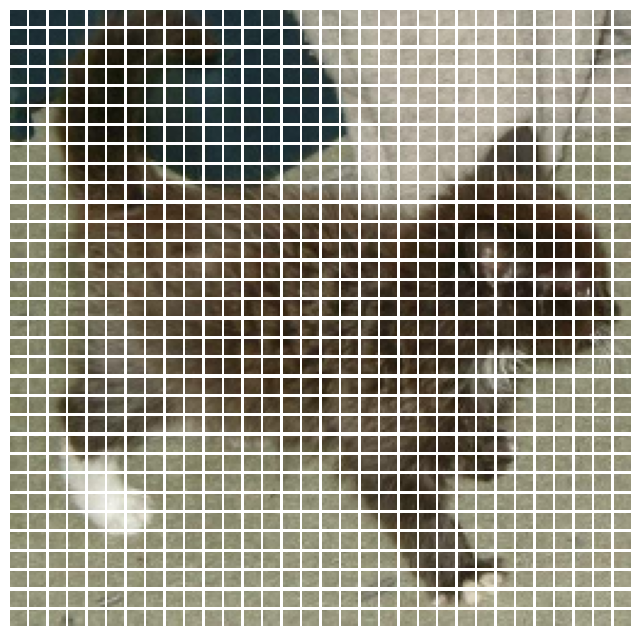

In [23]:
plt.figure(figsize=(8, 8))
image = next(iter(train_data))[0][5]

plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

print(resized_image.shape)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
#print(n)

plt.figure(figsize=(8, 8))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis("off")

In [24]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_of_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units = projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim = num_patches, output_dim = projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encode = self.projection(patch) + self.position_embedding(positions)
        return encode

In [25]:
def vit_model():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.BatchNormalization()(encoded_patches)
        # create a multi-head attention layer
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.BatchNormalization()(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization()(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP
    features = mlp(representation, hidden_units = mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes, activation='sigmoid')(features)
    # create keras model
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [28]:
def experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.AUC( name="AUC"),
        ],
     )
    checkpoint_filepath = "./tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(train_data ,
                        batch_size=batch_size,
                        epochs=20,
                        validation_data=validation_data,
                        callbacks=[checkpoint_callback],)
    model.load_weights(checkpoint_filepath)
    _, accuracy, auc = model.evaluate(validation_data)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test AUC: {round(auc * 100, 2)}%")

    return history

In [29]:
model = vit_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, 224, 224, 3)          7         ['input_2[0][0]']             
 ial)                                                                                             
                                                                                                  
 patches_2 (Patches)         (None, None, 147)            0         ['data_augmentation[1][0]']   
                                                                                                  
 patch_encoder_1 (PatchEnco  (None, 1024, 64)             75008     ['patches_2[0][0]']     

In [30]:
history = experiment(model)

Epoch 1/20
501/501 [==============================] - 266s 489ms/step - loss: 0.7042 - accuracy: 0.4993 - AUC: 0.4987 - val_loss: 0.6932 - val_accuracy: 0.4825 - val_AUC: 0.5000
Epoch 2/20
501/501 [==============================] - 244s 487ms/step - loss: 0.6932 - accuracy: 0.4929 - AUC: 0.4998 - val_loss: 0.6931 - val_accuracy: 0.4825 - val_AUC: 0.5000
Epoch 3/20
501/501 [==============================] - 244s 487ms/step - loss: 0.6932 - accuracy: 0.4966 - AUC: 0.4998 - val_loss: 0.6931 - val_accuracy: 0.5175 - val_AUC: 0.5000
Epoch 4/20
501/501 [==============================] - 244s 487ms/step - loss: 0.6933 - accuracy: 0.4951 - AUC: 0.5004 - val_loss: 0.6931 - val_accuracy: 0.5175 - val_AUC: 0.5000
Epoch 5/20
501/501 [==============================] - 243s 486ms/step - loss: 0.6931 - accuracy: 0.4967 - AUC: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5175 - val_AUC: 0.5000
Epoch 6/20
501/501 [==============================] - 243s 486ms/step - loss: 0.6932 - accuracy: 0.4948 - AUC:

In [31]:
classes=['cats','dogs']

In [44]:
def get_img_array(img):

    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [45]:
def gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output,  model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]


    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [37]:
conv_layer_name = 'layer_normalization_1'

In [48]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from matplotlib import cm

def display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=1, preds=[0,0], plot=None):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Display Grad CAM
    plot.imshow(superimposed_img)
    plot.set(title =
        "cats: \
        {:.3f}\ndogs: \
        {:.3f}".format(preds[0], \
                    preds[1])
    )
    plot.axis('off')

    # Add a colorbar to the plot
    mappable = cm.ScalarMappable(cmap=jet)
    mappable.set_array(heatmap)
    cbar = plt.colorbar(mappable, ax=plot)
    cbar.set_label('Intensity')


1/1 [==============================] - 0s 46ms/step


<ipython-input-48-691c54320734>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


1/1 [==============================] - 0s 41ms/step


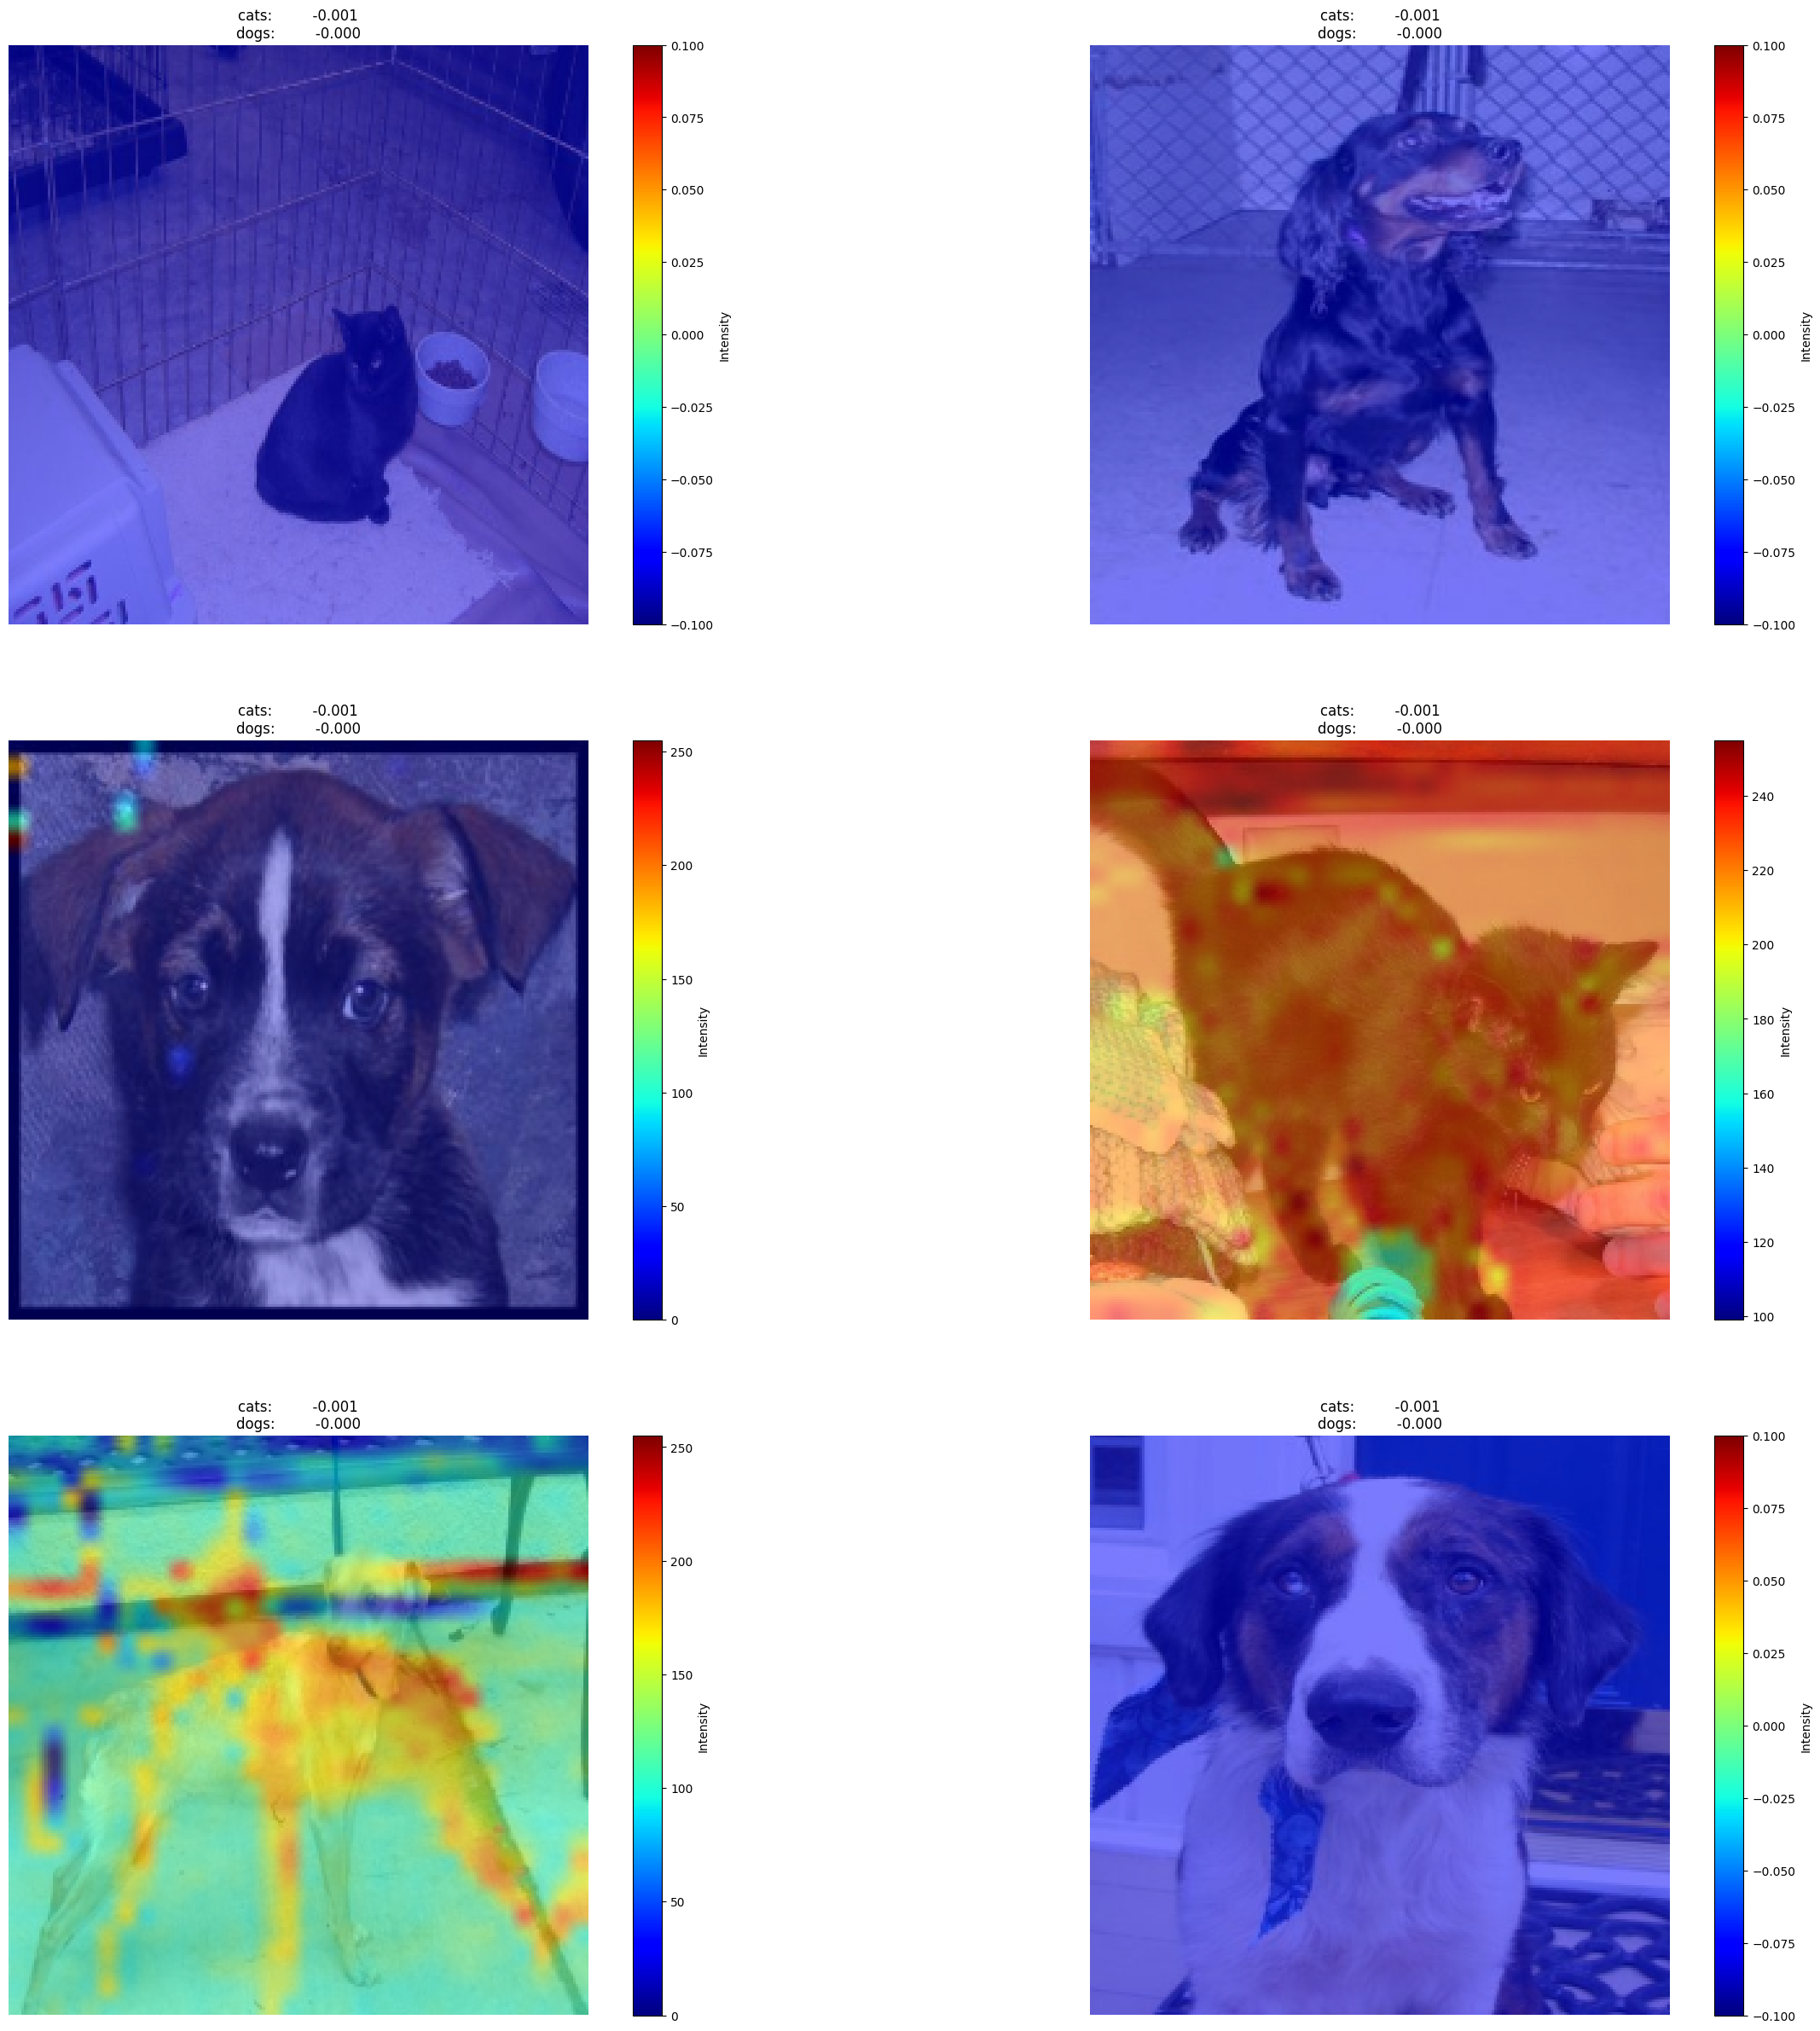

In [49]:
fig, axis = plt.subplots(3, 2, figsize=(30, 30))
for images, ax in zip(next(iter(validation_data))[0][:6], axis.flat):
    img_array = get_img_array(images)
    # Remove last layer's softmax
    model.layers[-1].activation = None
    # Print what the top predicted class is
    preds = model.predict(img_array)
    heatmap = gradcam_heatmap(img_array, model, conv_layer_name )

    heatmap = np.reshape(heatmap, (32,32))
    display_gradcam(images, heatmap, preds=preds[0], plot=ax)

1/1 [==============================] - 0s 42ms/step


<ipython-input-38-95d261d47646>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


1/1 [==============================] - 0s 54ms/step


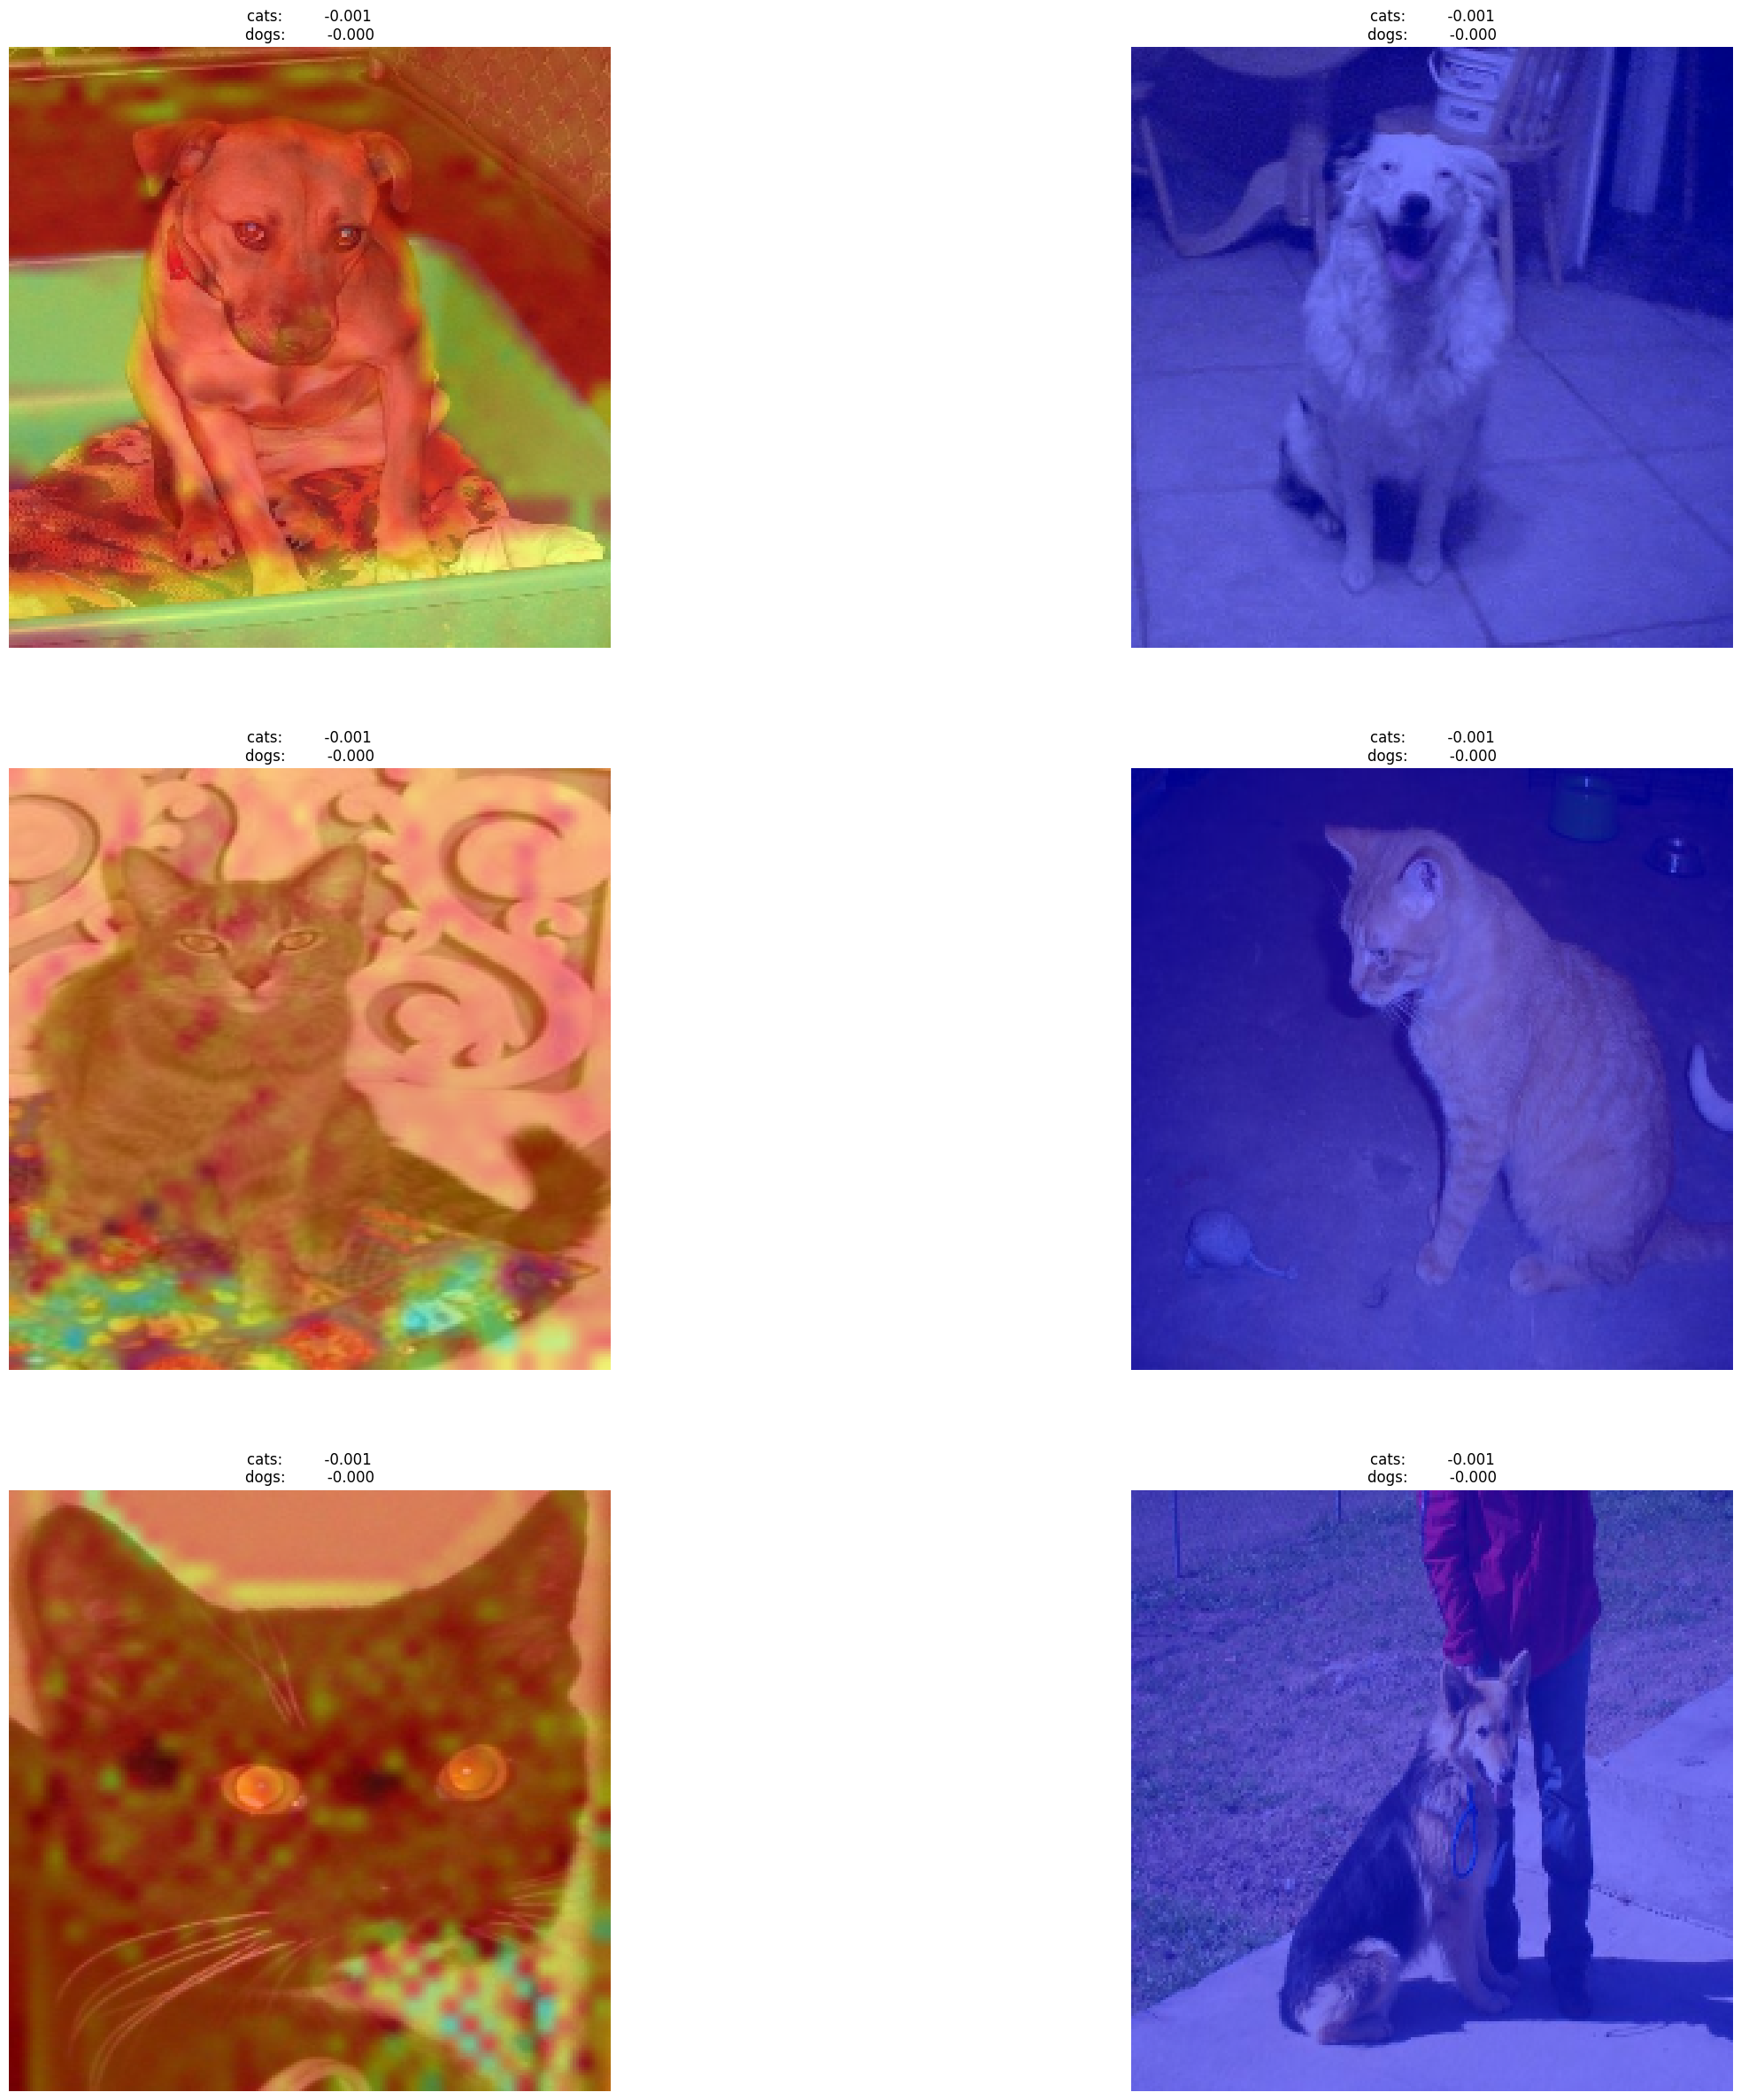

In [41]:
fig, axis = plt.subplots(3, 2, figsize=(30, 30))
for images, ax in zip(next(iter(validation_data))[0][6:12], axis.flat):
    img_array = get_img_array(images)
    # Remove last layer's softmax
    model.layers[-1].activation = None
    # Print what the top predicted class is
    preds = model.predict(img_array)
    heatmap = gradcam_heatmap(img_array, model, conv_layer_name)

    heatmap = np.reshape(heatmap, (32,32))
    display_gradcam(images, heatmap, preds=preds[0], plot=ax)